In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os

# TODO: Fill in the Google Drive path where you uploaded
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ML'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive/
['settings.py', 'Youtube01-Psy.csv', 'Youtube03-LMFAO.csv', 'Youtube02-KatyPerry.csv', 'Youtube04-Eminem.csv', 'Youtube05-Shakira.csv', 'get_comment_data.py', 'vectorize_data.py', 'vec_data_no_norm.py', 'initial_eda.py', 'word2vecdat.csv', 'word2vecdat_nopunc.csv', 'data_with_vectors.csv', 'data_with_vectors2.csv', 'data.csv', 'word2vec_model', 'word2vecdat_googlemodel.csv', 'data2.csv', 'ML_word2vec_model.ipynb', 'ted_hadley_Assignment_8.ipynb', 'word2vec_vectorize', 'ML_boosted_model_and_neural_net.ipynb']


In [3]:
# Note upload all necessary files to session storage before running
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import confusion_matrix, classification_report
from vec_data_no_norm import vectorize_data_no_norm

In [4]:
# Get bag o' words vectorization data
X, Y = vectorize_data_no_norm(normalize = False)



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# Get word2vec vectorization data
dat = pd.read_csv(GOOGLE_DRIVE_PATH + '/data2.csv')
X2 = dat.iloc[:,2:]
Y2 = dat.iloc[:,1]

In [6]:
# Optimize hyperparam of bag o' words data
import hyperopt
from hyperopt import hp, STATUS_OK
from hyperopt import Trials

In [8]:
def objective_svm(params):
  rf = SVC(**params)
  cv_results = cross_validate(rf, X, Y, cv = 3)
  acc = np.mean(cv_results['test_score'])
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_svm = {
      'C': hp.choice('C', np.arange(0.005,1.0,0.01)),
      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf']),
      'degree':hp.choice('degree',[2,3,4]),
      'probability':hp.choice('probability',[True])
      }

hyperopt.fmin(objective_svm,
              space = space_svm,
              algo = hyperopt.tpe.suggest,
              max_evals=20,
              trials = trials)
# Opt C 59, degree 1, kernel linear, prob 0

100%|██████████| 20/20 [00:25<00:00,  1.29s/it, best loss: -0.9105316973415133]


{'C': 59, 'degree': 1, 'kernel': 0, 'probability': 0}

In [9]:
def objective_rf(params):
  rf = RandomForestClassifier(**params,n_jobs=-1)
  cv_results = cross_validate(rf, X, Y, cv = 3)
  acc = np.mean(cv_results['test_score'])
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,200)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

hyperopt.fmin(objective_rf,
              space = space_rf,
              algo = hyperopt.tpe.suggest,
              max_evals=15,
              trials = trials)
# opt criterion 1, max_depth 18, max_features 31, n_estimators 26

100%|██████████| 15/15 [00:45<00:00,  3.03s/it, best loss: -0.9161554192229039]


{'criterion': 1, 'max_depth': 18, 'max_features': 31, 'n_estimators': 26}

In [28]:
X_params_rf = {'criterion':'entropy','max_depth':18,'max_features':31,'n_estimators': 26}
X_params_svm = {'C': 59, 'degree':1, 'kernel': 'linear'}

In [29]:
# Results from ML_word2vec_model.ipynb
X2_params_rf = {'criterion':'gini','max_depth':11,'max_features':11,'n_estimators': 297}
X2_params_svm = {'C': 77, 'degree':0, 'kernel': 'rbf'}

In [33]:
# Initial test for AdaBoost Classifier with decision tree estimators
ab = AdaBoostClassifier()
cv_results = cross_validate(ab, X, Y, cv = 5)
print(np.mean(cv_results['test_score'])) # Seems to work better with bag o' words model

ab = AdaBoostClassifier()
cv_results = cross_validate(ab, X2, Y2, cv = 5)
print(np.mean(cv_results['test_score']))

0.9243645284200637
0.8537464402981592


In [43]:
# Tune paramaters for AdaBoost
def objective_ab(params):
  rf = AdaBoostClassifier(**params)
  cv_results = cross_validate(rf, X, Y, cv = 5)
  acc = np.mean(cv_results['test_score'])
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(5,200)),
    'learning_rate': hp.uniform('learning_rate', 0, 5)
    }

hyperopt.fmin(objective_ab,
              space = space_ab,
              algo = hyperopt.tpe.suggest,
              max_evals=15,
              trials = trials)
# Opt learning rate 0.507, n_estimators 71

100%|██████████| 15/15 [00:25<00:00,  1.67s/it, best loss: -0.9258912260556397]


{'learning_rate': 0.507168286993479, 'n_estimators': 71}

In [44]:
# Tune paramaters for AdaBoost
def objective_ab(params):
  rf = AdaBoostClassifier(**params)
  cv_results = cross_validate(rf, X2, Y2, cv = 5)
  acc = np.mean(cv_results['test_score'])
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(5,200)),
    'learning_rate': hp.uniform('learning_rate', 0, 5)
    }

hyperopt.fmin(objective_ab,
              space = space_ab,
              algo = hyperopt.tpe.suggest,
              max_evals=15,
              trials = trials)

# Opt learning rate 0.507, n_estimators 71
# Opt learning_rate 0.321, n_estimators = 114

100%|██████████| 15/15 [04:43<00:00, 18.87s/it, best loss: -0.8693826737834767]


{'learning_rate': 0.3206377678488953, 'n_estimators': 114}

In [7]:
# Let's apply a neural network MLP architecture:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical


In [7]:
xtrain, xval, ytrain, yval= train_test_split(X, Y, test_size=.2)
x2train, x2val, y2train, y2val= train_test_split(X2, Y2, test_size=.2)

In [9]:
type(ytrain_1hot)

numpy.ndarray

In [18]:
ytrain_1hot = to_categorical(ytrain, num_classes = 2)
yval_1hot = to_categorical(yval, num_classes = 2)
y2train_1hot = to_categorical(y2train, num_classes = 2)
y2val_1hot = to_categorical(y2val, num_classes = 2)


In [30]:
def objective_nn(params):
    layer1_size, layer2_size, batch_size, epochs = params
    layers = [
        Flatten(),
        Dense(layer1_size, activation = 'relu'),
        Dense(layer2_size, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]

    model = Sequential(layers)

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

    history = model.fit(xtrain.to_numpy(), ytrain_1hot, batch_size=batch_size, epochs=epochs , validation_data=(xval.to_numpy(), yval_1hot))
    acc = model.evaluate(xval, yval_1hot)[1]
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_nn = [
    hp.choice('layer1_size', range(20,200)),
    hp.choice('layer2_size', range(20,200)),
    hp.choice('batch_size', range(10,500)),
    hp.choice('epochs', range(1,20))
]

hyperopt.fmin(objective_nn,
              space = space_nn,
              algo = hyperopt.tpe.suggest,
              max_evals=15,
              trials = trials)

# Opt l1 92, l2 91, bs 81, epochs 8

8/8 [==============================] - 1s 37ms/step - loss: 0.6650 - accuracy: 0.5179 - val_loss: 0.6470 - val_accuracy: 0.5536

13/13 [==============================] - 0s 12ms/step - loss: 0.6470 - accuracy: 0.5536

Epoch 1/2

5/5 [==============================] - 1s 47ms/step - loss: 0.6556 - accuracy: 0.5492 - val_loss: 0.6373 - val_accuracy: 0.5179

Epoch 2/2

5/5 [==============================] - 0s 14ms/step - loss: 0.6072 - accuracy: 0.5416 - val_loss: 0.6025 - val_accuracy: 0.6071

13/13 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6071

Epoch 1/6

4/4 [==============================] - 1s 64ms/step - loss: 0.6962 - accuracy: 0.4680 - val_loss: 0.6905 - val_accuracy: 0.5408

Epoch 2/6

4/4 [==============================] - 0s 15ms/step - loss: 0.6847 - accuracy: 0.5863 - val_loss: 0.6827 - val_accuracy: 0.5357

Epoch 3/6

4/4 [==============================] - 0s 17ms/step - loss: 0.6744 - accuracy: 0.5639 - val_loss: 0.6749 - val_accuracy: 0.

{'batch_size': 81, 'epochs': 8, 'layer1_size': 92, 'layer2_size': 91}

In [31]:
def objective_nn(params):
    layer1_size, layer2_size, batch_size, epochs = params
    layers = [
        Flatten(),
        Dense(layer1_size, activation = 'relu'),
        Dense(layer2_size, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]

    model = Sequential(layers)

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

    history = model.fit(x2train.to_numpy(), y2train_1hot, batch_size=batch_size, epochs=epochs , validation_data=(x2val.to_numpy(), y2val_1hot))
    acc = model.evaluate(x2val, y2val_1hot)[1]
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

space_nn = [
    hp.choice('layer1_size', range(20,200)),
    hp.choice('layer2_size', range(20,200)),
    hp.choice('batch_size', range(10,500)),
    hp.choice('epochs', range(1,20))
]

hyperopt.fmin(objective_nn,
              space = space_nn,
              algo = hyperopt.tpe.suggest,
              max_evals=15,
              trials = trials)
#Opt {'batch_size': 45, 'epochs': 14, 'layer1_size': 172, 'layer2_size': 45}

Epoch 1/15

5/5 [==============================] - 1s 60ms/step - loss: 0.6666 - accuracy: 0.6246 - val_loss: 0.6157 - val_accuracy: 0.8468

Epoch 2/15

5/5 [==============================] - 0s 15ms/step - loss: 0.5861 - accuracy: 0.8576 - val_loss: 0.5314 - val_accuracy: 0.8468

Epoch 3/15

5/5 [==============================] - 0s 20ms/step - loss: 0.4911 - accuracy: 0.8653 - val_loss: 0.4475 - val_accuracy: 0.8524

Epoch 4/15

5/5 [==============================] - 0s 15ms/step - loss: 0.4008 - accuracy: 0.8681 - val_loss: 0.3908 - val_accuracy: 0.8552

Epoch 5/15

5/5 [==============================] - 0s 16ms/step - loss: 0.3359 - accuracy: 0.8800 - val_loss: 0.3649 - val_accuracy: 0.8663

Epoch 6/15

5/5 [==============================] - 0s 20ms/step - loss: 0.2923 - accuracy: 0.8932 - val_loss: 0.3495 - val_accuracy: 0.8719

Epoch 7/15

5/5 [==============================] - 0s 14ms/step - loss: 0.2608 - accuracy: 0.9065 - val_loss: 0.3350 - val_accuracy: 0.8886

Epoch 8/15

5

{'batch_size': 45, 'epochs': 14, 'layer1_size': 172, 'layer2_size': 45}

In [9]:
# Get Final results for all tuned hyperparams and all models: CV, k = 10
X_params_rf = {'criterion':'entropy','max_depth':18,'max_features':31,'n_estimators': 26}
X_params_svm = {'C': 59, 'degree':1, 'kernel': 'linear'}
X_params_ab = {'n_estimators': 71, 'learning_rate': 0.507}
X_params_nn = {'layer1_size': 92, 'layer2_size': 91, 'batch_size': 81, 'epochs': 8}

X2_params_rf = {'criterion':'gini','max_depth':11,'max_features':11,'n_estimators': 297}
X2_params_svm = {'C': 77, 'degree':0, 'kernel': 'rbf'}
X2_params_ab = {'n_estimators': 114, 'learning_rate': 0.321}
X2_params_nn = {'layer1_size': 172, 'layer2_size': 45, 'batch_size': 45, 'epochs': 14}

# Opt l1 92, l2 91, bs 81, epochs 8
#Opt {'batch_size': 45, 'epochs': 14, 'layer1_size': 172, 'layer2_size': 45}

In [35]:
accs = []
accs2 = []

svm = SVC(C = X_params_svm['C'], degree = X_params_svm['degree'], kernel = X_params_svm['kernel'])
cv_results = cross_validate(svm, X, Y, cv = 10)
accs.append(np.mean(cv_results['test_score']))

svm = SVC(C = X2_params_svm['C'], degree = X2_params_svm['degree'], kernel = X2_params_svm['kernel'])
cv_results = cross_validate(svm, X2, Y2, cv = 10)
accs2.append(np.mean(cv_results['test_score']))

rf = RandomForestClassifier(criterion = X_params_rf['criterion'], max_depth = X_params_rf['max_depth'], max_features = X_params_rf['max_features'], n_estimators = X_params_rf['n_estimators'])
cv_results = cross_validate(rf, X, Y, cv = 10)
accs.append(np.mean(cv_results['test_score']))

rf = RandomForestClassifier(criterion = X2_params_rf['criterion'], max_depth = X2_params_rf['max_depth'], max_features = X2_params_rf['max_features'], n_estimators = X2_params_rf['n_estimators'])
cv_results = cross_validate(rf, X2, Y2, cv = 10)
accs2.append(np.mean(cv_results['test_score']))

ab = AdaBoostClassifier(n_estimators = X_params_ab['n_estimators'], learning_rate = X_params_ab['learning_rate'])
cv_results = cross_validate(ab, X, Y, cv = 10)
accs.append(np.mean(cv_results['test_score']))

ab = AdaBoostClassifier(n_estimators = X2_params_ab['n_estimators'], learning_rate = X2_params_ab['learning_rate'])
cv_results = cross_validate(ab, X2, Y2, cv = 10)
accs2.append(np.mean(cv_results['test_score']))




In [38]:
def MLP_nn(X, Y, layer1_size, layer2_size, batch_size, epochs):
    # Split data
    xtrain, xval, ytrain, yval= train_test_split(X, Y, test_size=.2)
    ytrain_1hot = to_categorical(ytrain, num_classes = 2)
    yval_1hot = to_categorical(yval, num_classes = 2)

    layers = [
        Flatten(),
        Dense(layer1_size, activation = 'relu'),
        Dense(layer2_size, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]

    model = Sequential(layers)

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

    history = model.fit(xtrain.to_numpy(), ytrain_1hot, batch_size=batch_size, epochs=epochs , validation_data=(xval.to_numpy(), yval_1hot))
    acc = model.evaluate(xval, yval_1hot)[1]
    return acc

In [39]:
accs.append(MLP_nn(X, Y, layer1_size = X_params_nn['layer1_size'], layer2_size = X_params_nn['layer2_size'], batch_size = X_params_nn['batch_size'], epochs = X_params_nn['epochs']))
accs2.append(MLP_nn(X2, Y2, layer1_size = X2_params_nn['layer1_size'], layer2_size = X2_params_nn['layer2_size'], batch_size = X2_params_nn['batch_size'], epochs = X2_params_nn['epochs']))

Epoch 1/8
20/20 [==============================] - 1s 12ms/step - loss: 0.6272 - accuracy: 0.6023 - val_loss: 0.5586 - val_accuracy: 0.7577
Epoch 2/8
20/20 [==============================] - 0s 5ms/step - loss: 0.4916 - accuracy: 0.8517 - val_loss: 0.4096 - val_accuracy: 0.9362
Epoch 3/8
20/20 [==============================] - 0s 5ms/step - loss: 0.3171 - accuracy: 0.9361 - val_loss: 0.2793 - val_accuracy: 0.9439
Epoch 4/8
20/20 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9488 - val_loss: 0.2328 - val_accuracy: 0.9413
Epoch 5/8
20/20 [==============================] - 0s 6ms/step - loss: 0.1299 - accuracy: 0.9616 - val_loss: 0.2313 - val_accuracy: 0.9515
Epoch 6/8
20/20 [==============================] - 0s 4ms/step - loss: 0.1005 - accuracy: 0.9693 - val_loss: 0.2377 - val_accuracy: 0.9541
Epoch 7/8
20/20 [==============================] - 0s 5ms/step - loss: 0.0851 - accuracy: 0.9725 - val_loss: 0.2484 - val_accuracy: 0.9541
Epoch 8/8
13/13 [=========

In [12]:
# Let's train our best model to get confusion matrix
xtrain, xval, ytrain, yval= train_test_split(X, Y, test_size=.2)
ytrain_1hot = to_categorical(ytrain, num_classes = 2)
yval_1hot = to_categorical(yval, num_classes = 2)

layers = [
    Flatten(),
    Dense(X_params_nn['layer1_size'], activation = 'relu'),
    Dense(X_params_nn['layer2_size'], activation = 'relu'),
    Dense(2, activation = 'softmax')
]

model = Sequential(layers)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

history = model.fit(xtrain.to_numpy(), ytrain_1hot, batch_size=X_params_nn['batch_size'], epochs=X_params_nn['epochs'], validation_data=(xval.to_numpy(), yval_1hot))


Epoch 1/8
20/20 [==============================] - 1s 9ms/step - loss: 0.6339 - accuracy: 0.5921 - val_loss: 0.5924 - val_accuracy: 0.6199
Epoch 2/8
20/20 [==============================] - 0s 6ms/step - loss: 0.5156 - accuracy: 0.7890 - val_loss: 0.4513 - val_accuracy: 0.9082
Epoch 3/8
20/20 [==============================] - 0s 4ms/step - loss: 0.3535 - accuracy: 0.9214 - val_loss: 0.2816 - val_accuracy: 0.9515
Epoch 4/8
20/20 [==============================] - 0s 4ms/step - loss: 0.2166 - accuracy: 0.9418 - val_loss: 0.1952 - val_accuracy: 0.9592
Epoch 5/8
20/20 [==============================] - 0s 4ms/step - loss: 0.1459 - accuracy: 0.9540 - val_loss: 0.1622 - val_accuracy: 0.9541
Epoch 6/8
20/20 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9636 - val_loss: 0.1526 - val_accuracy: 0.9592
Epoch 7/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9706 - val_loss: 0.1532 - val_accuracy: 0.9541
Epoch 8/8
20/20 [==========

In [26]:
pred = model.predict(xval)
pred_round = np.round(pred)
predictions = [int(pred[1] == 1) for pred in pred_round]

13/13 [==============================] - 0s 1ms/step


In [33]:
tf.math.confusion_matrix(yval.to_list(),
                         predictions,
                         num_classes=2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[193,  10],
       [  7, 182]], dtype=int32)>

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


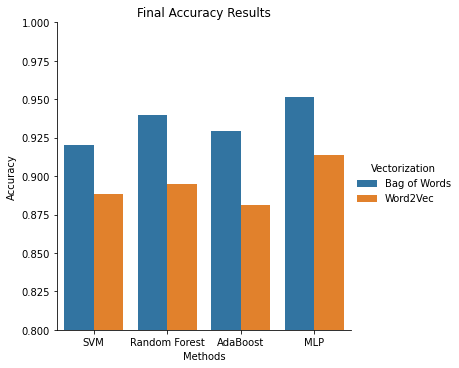

In [51]:
methods = ['SVM', 'Random Forest', 'AdaBoost', 'MLP']
df = pd.DataFrame({'Methods': methods, 
                   'Bag of Words': accs,
                   'Word2Vec': accs2})
new_df = pd.melt(df, id_vars = 'Methods')
new_df = new_df.rename(columns={'variable': 'Vectorization', 'value': 'Accuracy'})

import seaborn as sns
import matplotlib.pyplot as plt

sns.factorplot(x='Methods', y='Accuracy', hue='Vectorization', data = new_df, kind = 'bar')
plt.ylim(0.8, 1)
plt.title('Final Accuracy Results')
plt.show()
# Create bar plot

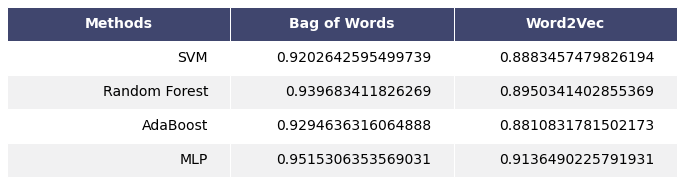

In [55]:
import six

# DF to img code from stack exchange
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df, header_columns=0, col_width=4.0)